In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Introduction
### This notebook introduces gradient descent with several step size functions(learning rate).

## 1 Data preprocessing

### Parkisons Dataset:

In [2]:
# parkinsons_updrs.data
# https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring
parkinsons_df = pd.read_csv('./parkinsons_updrs.data')

In [3]:
parkinsons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [4]:
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
corr = parkinsons_df.corr()["total_UPDRS"].abs().sort_values(ascending=False) 
corr[corr > 0.30]

total_UPDRS    1.000000
motor_UPDRS    0.947231
age            0.310290
Name: total_UPDRS, dtype: float64

In [6]:
cols = ['motor_UPDRS','age','total_UPDRS']
parkinsons_df = parkinsons_df[cols]

In [7]:
def SplitData(df, target):
    # Shuffling
    df = df.sample(frac=1)

    # Split data set into train(80%) and test(20%) sets
    num_train = int(len(df)*0.8)
    train_set = df[:num_train]
    test_set = df[num_train:]

    y_train = train_set[target].to_numpy()
    x_train = train_set.drop([target], axis=1).to_numpy()
    y_test = test_set[target].to_numpy()
    x_test = test_set.drop([target], axis=1).to_numpy()
    
    print(f'#total: {len(df)},  #xtrain: {x_train.shape}, #ytrain: {y_train.shape}, #xtest: {x_test.shape}, #xtest: {y_test.shape}')
    return x_train, y_train, x_test, y_test

In [8]:
# parkinsons_df
px_train, py_train, px_test, py_test = SplitData(parkinsons_df, "total_UPDRS")

#total: 5875,  #xtrain: (4700, 2), #ytrain: (4700,), #xtest: (1175, 2), #xtest: (1175,)


## 2. Linear Regression with Gradient Descent

### 2.1 Using Fixed Step length

In [9]:
def MSE(X, y, beta):
    diff = np.dot(X,beta)-y 
    loss = np.sum(diff**2) / (2*X.shape[0])
    return diff, loss

def RMSE(y_pred, y):
    RMSE = np.sqrt(np.sum((y_pred-y)**2)/len(y))
    return RMSE
    
def minimize_GD(X, y, Xtest, Ytest, beta, iterations, tolerance):

    Loss =[0]
    Diff =[]
    RMSE_list = []
    for i in range(iterations):
        diff, loss = MSE(X, y, beta)
        gradient = np.dot(X.T, diff) / X.shape[0]
        beta = beta - 1e-5 * gradient
        RMSE_list.append(RMSE(np.matmul(Xtest, beta), Ytest))
        Loss.append(loss)
        Diff.append(abs(Loss[i]-Loss[i+1]))
        if Diff[i] < tolerance:
            break
        loss_old = loss
        
    #print('MSE on train set:', loss)
    
    return beta, Diff, RMSE_list
    
def learn_linreg_GD(X, y, Xtest, Ytest, iterations, tolerance):
    
    # Initial values
    beta0 = np.zeros(X.shape[1])
    beta, diff, RMSE_list = minimize_GD(X, y, Xtest, Ytest, beta0, iterations, tolerance)
    
    return beta, diff, RMSE_list




In [10]:
pbeta, pdiff, RMSE_p_fx = learn_linreg_GD(px_train, py_train, px_test, py_test, 100, .001)

Text(0.5, 1.0, 'RMSE(test parkinsons set)')

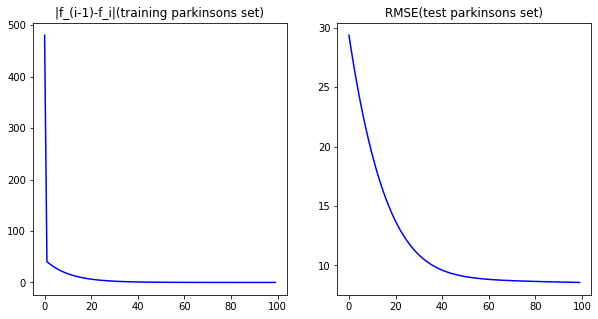

In [11]:
f = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(pdiff, 'b')
plt.title("|f_(i-1)-f_i|(training parkinsons set)")
plt.subplot(122)
plt.plot(RMSE_p_fx, 'b')
plt.title("RMSE(test parkinsons set)")

### 2.2 Using stepsize_backtracking

In [12]:
def stepsize_backtracking(g, beta, loss, X, y):
    mu = 1
    alpha = 0.5
    beta = 0.65
    _, cond1 = MSE(X, y, beta - mu*g)
    while cond1  > loss - alpha*mu*np.dot(g.T,g):
        mu *= beta 
        _, cond1 = MSE(X, y, beta - mu*g)
       
    return mu
    
def minimize_GD(X, y, Xtest, Ytest, beta, iterations, tolerance):

    Loss =[0]
    Diff =[]
    RMSE_list = []
    for i in range(iterations):
        diff, loss = MSE(X, y, beta)
        gradient = np.dot(X.T, diff) / X.shape[0]
        beta = beta - stepsize_backtracking(gradient, beta, loss, X, y) * gradient
        RMSE_list.append(RMSE(np.matmul(Xtest, beta), Ytest))
        Loss.append(loss)
        Diff.append(abs(Loss[i]-Loss[i+1]))
        if Diff[i] < tolerance:
            break
        loss_old = loss
        
    #print('MSE on train set:', loss)
    
    return beta, Diff, RMSE_list

In [13]:
pbeta, pdiff, RMSE_p_bt = learn_linreg_GD(px_train, py_train, px_test, py_test, 100, .001)

Text(0.5, 1.0, 'RMSE(test parkinsons set)')

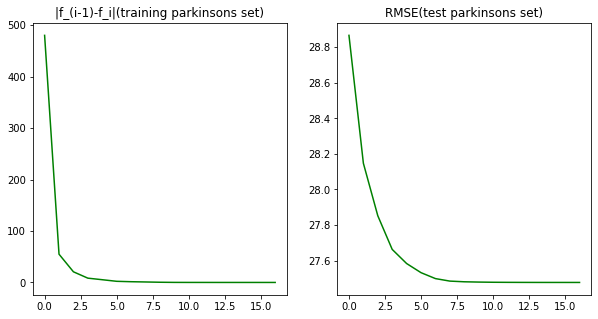

In [14]:
f = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(pdiff, 'g')
plt.title("|f_(i-1)-f_i|(training parkinsons set)")
plt.subplot(122)
plt.plot(RMSE_p_bt, 'g')
plt.title("RMSE(test parkinsons set)")

### 2.3 Using steplength_bolddriver

In [15]:
def steplength_bolddriver(g, beta, loss, X, y):
    mu = 1
    _, cond1 = MSE(X, y, beta - mu*g)
    
    while loss - cond1 <= 0:
        mu *= 0.5
        _, cond1 = MSE(X, y, beta - mu*g)
       
    return mu
    
def minimize_GD(X, y, Xtest, Ytest, beta, iterations, tolerance):

    Loss =[0]
    Diff =[]
    RMSE_list = []
    for i in range(iterations):
        diff, loss = MSE(X, y, beta)
        gradient = np.dot(X.T, diff) / X.shape[0]
        beta = beta - steplength_bolddriver(gradient, beta, loss, X, y) * gradient
        RMSE_list.append(RMSE(np.matmul(Xtest, beta), Ytest))
        Loss.append(loss)
        Diff.append(abs(Loss[i]-Loss[i+1]))
        if Diff[i] < tolerance:
            break
        loss_old = loss
        
    #print('MSE on train set:', loss)
    
    return beta, Diff, RMSE_list

In [16]:
pbeta, pdiff, RMSE_p_bo = learn_linreg_GD(px_train, py_train, px_test, py_test, 100, .001)

Text(0.5, 1.0, 'RMSE(test parkinsons set)')

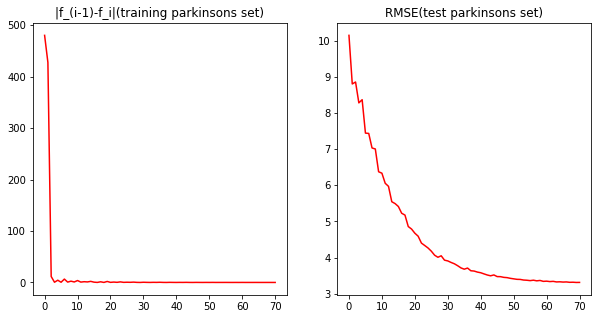

In [17]:
f = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(pdiff, 'r')
plt.title("|f_(i-1)-f_i|(training parkinsons set)")
plt.subplot(122)
plt.plot(RMSE_p_bo, 'r')
plt.title("RMSE(test parkinsons set)")

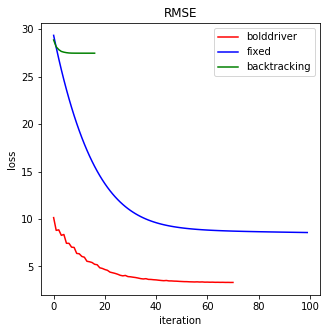

In [18]:
f = plt.figure(figsize=(5,5))
plt.plot(RMSE_p_bo, 'r')
plt.plot(RMSE_p_fx, 'b')
plt.plot(RMSE_p_bt, 'g')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('RMSE')
plt.legend(['bolddriver','fixed','backtracking'])